# Get average number of patches per slide

In [23]:
import os
import h5py
import tqdm
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

In [24]:
os.chdir('/data/pathology/projects/ais-cap/code/git/clemsgrs/hipt')

In [25]:
root_dir = Path('/data/pathology/projects/ais-cap/code/git/clemsgrs/hs2p')

In [26]:
dataset_name = 'tcga_brca'
experiment_name = 'otsu_spacing'
patch_dir = Path(root_dir, 'output', dataset_name, experiment_name, 'patches')

In [27]:
patch_size = 4096

In [28]:
slide_patches = [s for s in patch_dir.iterdir()]
len(slide_patches)

875

In [29]:
data = defaultdict(list)
for d in slide_patches:
    slide_dir = Path(d, str(patch_size))
    slide_id = d.name
    h5py_fp = Path(slide_dir, f'{slide_id}.h5')
    p = h5py.File(h5py_fp, 'r')['coords']
    m = len(p)
    data['slide_id'].append(slide_id)
    data['M'].append(m)

In [30]:
M_df = pd.DataFrame.from_dict(data)
M_df.head()

,slide_id,M
0,TCGA-A2-A0CQ-01Z-00-DX1.4E5FB4E5-A08C-4C87-A3B...,29
1,TCGA-W8-A86G-01Z-00-DX2.DEC2CC1C-3662-43C6-A5C...,32
2,TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF4...,109
3,TCGA-A2-A4S2-01Z-00-DX1.D779B63B-8817-43F1-A8F...,60
4,TCGA-E2-A1B5-01Z-00-DX1.AB19FF3D-5C42-4D49-ABE...,69


In [31]:
M_df.M.mean()

52.093714285714285

In [32]:
M_df.M.min(), M_df.M.max()

(4, 177)

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
nslide = defaultdict(list)
dfs = []
nfold = 10
for i in range(nfold):
    fold_dir = Path(f'data/{dataset_name}/splits/fold_{i}')
    for partition in ['train', 'tune', 'test']:
        df = pd.read_csv(Path(fold_dir, f'{partition}.csv'))
        nslide[partition].append(len(df))
        df = M_df.merge(df, how='inner', on='slide_id')
        M = df.M.mean()
        tmp = pd.DataFrame.from_dict({'avg_M': [M], 'partition': [partition]})
        dfs.append(tmp)
        
df = pd.concat(dfs)
df.head()

,avg_M,partition
0,171.423776,train
0,182.886076,tune
0,182.641975,test
0,170.917018,train
0,190.750000,tune


In [14]:
avg_nslide = [np.mean(nslide[p]) for p in ['train', 'tune', 'test']]
avg_nslide

[712.9, 79.9, 82.2]

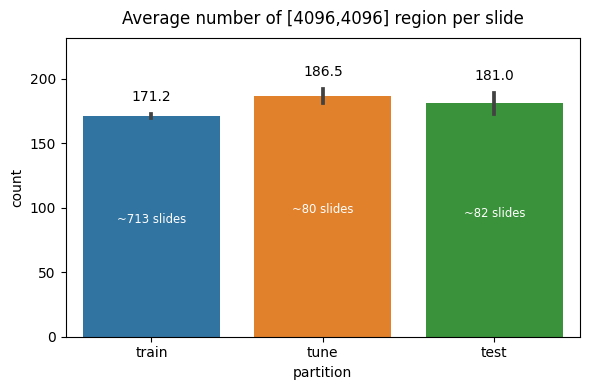

In [17]:
pad = 10
save = True

plt.figure(dpi=100)
ax = sns.barplot(data=df, y='avg_M', x='partition', errorbar='sd')
for i, p in enumerate(ax.patches):
    errbar = ax.lines[i].get_data()[1]
    std = errbar[1] - errbar[0]
    
    x, y = p.get_x(), p.get_y()
    w, h = p.get_width(), p.get_height()
    txt_x, txt_y = x+w/2, h+std/2+pad
    
    plt.text(txt_x, txt_y, f'{h:.1f}', horizontalalignment='center')
    
    n = avg_nslide[i]
    plt.text(x+w/2, h/2, f'~{n:.0f} slides', horizontalalignment='center', verticalalignment='bottom', fontsize='small', color='white')

plt.xlabel('partition')
plt.ylabel('count')
plt.ylim(0,df.avg_M.max()*1.2)
plt.title(f'Average number of [4096,4096] region per slide', pad=10)
plt.tight_layout()
if save:
    plt.savefig('notebooks/avg_M_partion.png', dpi=300)
plt.show()

### Breakdown per subtype

In [18]:
nslide = {'train': defaultdict(list), 'tune': defaultdict(list), 'test': defaultdict(list)}
dfs = []
nfold = 10
for i in range(nfold):
    fold_dir = Path(f'data/{dataset_name}/splits/fold_{i}')
    for partition in ['train', 'tune', 'test']:
        df = pd.read_csv(Path(fold_dir, f'{partition}.csv'))
        df['subtype'] = df['label'].apply(lambda x: 'IDC' if x == 0 else 'ILC')
        for subtype, gdf in df.groupby('subtype'):
            nslide[partition][subtype].append(len(gdf))
            gdf = M_df.merge(gdf, how='inner', on='slide_id')
            M = gdf.M.mean()
            tmp = pd.DataFrame.from_dict({'avg_M': [M], 'partition': [partition], 'subtype': [subtype]})
            dfs.append(tmp)
        
df = pd.concat(dfs)
df.head()

,avg_M,partition,subtype
0,171.589615,train,IDC
0,170.584746,train,ILC
0,182.437500,tune,IDC
0,184.800000,tune,ILC
0,184.861538,test,IDC


In [19]:
nslide

{'train': defaultdict(list,
             {'IDC': [597, 587, 598, 588, 595, 595, 589, 595, 588, 589],
              'ILC': [118, 124, 120, 120, 121, 121, 123, 120, 121, 120]}),
 'tune': defaultdict(list,
             {'IDC': [64, 71, 65, 67, 68, 65, 68, 61, 69, 66],
              'ILC': [15, 13, 15, 14, 12, 12, 13, 14, 13, 14]}),
 'test': defaultdict(list,
             {'IDC': [65, 68, 63, 71, 63, 66, 69, 70, 69, 71],
              'ILC': [16, 12, 14, 15, 16, 16, 13, 15, 15, 15]})}

In [20]:
avg_nslide = [np.mean(nslide[p][s]) for s in df.subtype.unique() for p in ['train', 'tune', 'test']]
avg_nslide

[592.1, 66.4, 67.5, 120.8, 13.5, 14.7]

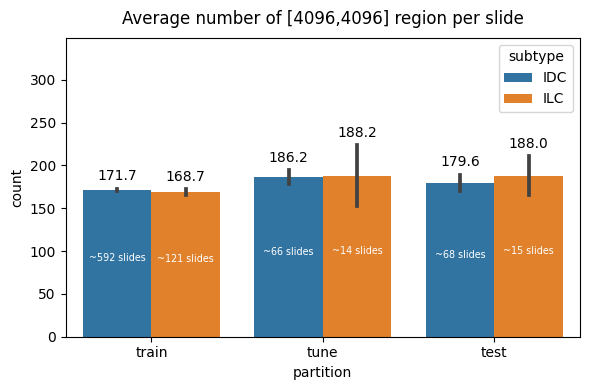

In [26]:
pad = 10
save = True

plt.figure(dpi=100)
ax = sns.barplot(data=df, y='avg_M', hue='subtype', x='partition', errorbar='sd')
for i, p in enumerate(ax.patches):
    errbar = ax.lines[i].get_data()[1]
    std = errbar[1] - errbar[0]
    
    x, y = p.get_x(), p.get_y()
    w, h = p.get_width(), p.get_height()
    txt_x, txt_y = x+w/2, h+std/2+pad
    
    plt.text(txt_x, txt_y, f'{h:.1f}', horizontalalignment='center')
    
    n = avg_nslide[i]
    plt.text(x+w/2, h/2, f'~{n:.0f} slides', horizontalalignment='center', verticalalignment='bottom', fontsize='x-small', color='white')

plt.xlabel('partition')
plt.ylabel('count')
plt.ylim(0,349)
plt.title(f'Average number of [4096,4096] region per slide', pad=10)
plt.tight_layout()
if save:
    plt.savefig('notebooks/avg_M_subtype.png', dpi=300)
plt.show()

#### Compute number of regions from HIPT pre-extracted features

In [4]:
import tqdm
import torch
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

In [5]:
hipt_dir = Path('/home/user/code/git/opensource/tmp/HIPT')
d = 'embeddings_slide_lib'
features_root_dir = Path(hipt_dir, f'3-Self-Supervised-Eval/{d}/{d}/vit256mean_tcga_slide_embeddings')

In [6]:
features_fp = list(features_root_dir.glob('*.pt'))
len(features_fp)

875

In [7]:
data = defaultdict(list)

with tqdm.tqdm(
    features_fp,
    desc='Loading features',
    unit=' slide',
    ncols=80,
    leave=True,
) as t:
    for fp in t:
        slide_id = fp.stem
        feat = torch.load(fp)
        m = feat.shape[0]
        data['slide_id'].append(slide_id)
        data['M'].append(m)

Loading features: 100%|███████████████████| 875/875 [00:10<00:00, 87.28 slide/s]


In [8]:
M_df = pd.DataFrame.from_dict(data)
M_df.head()

,slide_id,M
0,TCGA-B6-A0X4-01Z-00-DX1.4B7914DE-3436-4D69-9BC...,46
1,TCGA-D8-A1XF-01Z-00-DX2.1460E522-5B87-4690-8B6...,28
2,TCGA-B6-A0X7-01Z-00-DX1.A2AA8FE9-CF43-434A-AE7...,43
3,TCGA-A2-A0YG-01Z-00-DX1.89A39319-F880-47DE-B31...,18
4,TCGA-BH-A0BP-01Z-00-DX1.63A87C1D-87FA-494D-983...,10


In [9]:
M_df.M.mean()

29.698285714285714

In [10]:
M_df.M.min(), M_df.M.max()

(1, 122)